In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from scipy import special
from scipy.integrate import solve_ivp
from numpy.polynomial.legendre import legfit, legval
%matplotlib inline

In [2]:
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (9,5)
plt.rcParams["figure.dpi"] = 200

## Problem 1

In [3]:
def recursive_integrate(func, start, stop, tol=1e-3, conserve_calls=True, old_yvals=None):
    """
    Integrate a real-valued function using a variable step size. Adapted from class.
    
    Parameters
    ----------
    func: callable
        Function to integrate; must take an ndarray as an argument and
        return an ndarray of equal length to the input.
    start: float
        Start of the interval to integrate the function over.
    stop: float
        End of the interval to integrate the function over.
    tol: float, optional
        Maximum allowable error in the approximation of the integral. Default
        is 0.001.
    conserve_calls: bool, optional
        Whether or not to reduce the number of points at which the provided
        function is evaluated.
    yvals: length-3 ndarray, optional
        Not intended for use by the end user; only for reducing the number of
        values at which func is evaluated.
    
    Returns
    -------
    integral: float
        Numerical integral of the input function on the specified domain.
    """
    # Partition the interval into four slices.
    xvals = np.linspace(start, stop, 5)
    width = stop - start
    
    # Only sample points that haven't yet been sampled *if care is desired*
    if old_yvals is None:
        yvals = func(xvals)
    else:
        yvals = np.empty(5)
        yvals[::2] = old_yvals
        yvals[1::2] = func(xvals[1::2])
        
    # Use Simpson's Rule to estimate the integral.
    rough_weights = np.array([1, 4, 1]) / 6
    fine_weights = np.array([1, 4, 2, 4, 1]) / 12
    rough_integral = width * rough_weights @ yvals[::2]
    fine_integral = width * fine_weights @ yvals
    
    # Estimate the error by comparing the rough partition to the finer partition.
    error = np.abs(fine_integral - rough_integral)
    if error < tol:
        return fine_integral
    else:
        # Refine the partition and try again on each resulting half if needed.
        midpoint = 0.5 * (start + stop)
        first_yvals = yvals[:3] if conserve_calls else None
        first_integral = recursive_integrate(
            func, start, midpoint, 0.5 * tol, conserve_calls, first_yvals
        )
        second_yvals = yvals[2:] if conserve_calls else None
        second_integral = recursive_integrate(
            func, midpoint, stop, 0.5 * tol, conserve_calls, second_yvals
        )
        return first_integral + second_integral

The above implementation might not be the best implementation for cutting down on the number of function calls, but it's the fastest of the different implementations I've tried, and also the most compact.

In [4]:
# Test it with something analytic. Let's do 1/x from 1 to 2.
def monomial(x, degree):
    """Evaluate a monomial of a specified degree."""
    return x ** degree

truth = np.log(2)
estimate = recursive_integrate(lambda x: monomial(x, -1), 1, 2)
error = truth - estimate
print(error)

-7.350094585301115e-06


Let's do some timing tests to see if we actually get a speedup from not evaluating the function at points that have already been sampled.

In [5]:
%%timeit
integral = recursive_integrate(lambda x: monomial(x, -1), 1, 10, conserve_calls=False)

462 µs ± 6.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
%%timeit
integral = recursive_integrate(lambda x: monomial(x, -1), 1, 10, conserve_calls=True)

501 µs ± 2.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This suggests that there's actually more computational overhead involved in avoiding repeated function calls than there are savings from the fewer x-values at which the function is evaluated. This might not hold for something more complicated, though. So let's do some exploring with different functions.

In [7]:
%%timeit
integral = recursive_integrate(lambda x: special.airy(x)[0], -10, 10, conserve_calls=False)

2.6 ms ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%%timeit
integral = recursive_integrate(lambda x: special.airy(x)[0], -10, 10, conserve_calls=True)

2.83 ms ± 54.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Looks like the airy function evaluation is efficient enough so that reducing the number of points the function is evaluated at does not give us more time than it costs to do the checking for reducing the number of calls.

In [9]:
def clipped_sine(x):
    """Sine clipped to be between -0.5 and 0.5."""
    result = np.sin(x)
    result = np.where(result > 0.5, 0.5, result)
    result = np.where(result < -0.5, -0.5, result)
    return result

In [10]:
%%timeit
integral = recursive_integrate(clipped_sine, -10, 10, conserve_calls=False)

34.5 µs ± 501 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%%timeit
integral = recursive_integrate(clipped_sine, -10, 10, conserve_calls=True)

34.5 µs ± 321 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Hmmm... Still not complicated enough of a function for us to have an improvement in performance.

It seems like the moral of this story is that reducing the number of points the function is evaluated at does not provide us a performance boost for a large class of functions. I can see this being useful for something where evaluating the function is actually quite expensive&mdash;at least more expensive than creating and filling in a few buffer arrays, along with the extra logic needed to allow for the feature to be easily switched on or off. Either way, let's get an idea of how many computations we save by turning on the feature for not evaluating points we have already sampled.  
  
We always sample the function at least 5 times for the first iteration. Counting is a little tricky here, since this implementation is doubly recursive in a kind of weird way. Let's suppose our first iteration wasn't good enough, so we refine our partition and now calculate two more integrations, each with five sample points. So two iterations in, and we've gone from 5 samples to 15 samples. If we don't resample points that have already been sampled, then we instead have 9 samples, since each new iteration only adds two new points. In fact, each iteration beyond the first adds 10 more sample points if we aren't careful, but only adds 4 more if we are careful. So being careful saves us $6N$ samples of the function if we iterate $N$ times beyond the initial iteration. In other words, if we zero-index our recursion depth, then being careful about resampling saves us $6N$ evaluations of the function for a recursion depth of $N$.

## Problem 2

In [12]:
def build_cheb_basis(xvals, order):
    """
    Build a matrix of Chebyshev basis vectors evaluated at each provided x.
    """
    basis = np.zeros([xvals.size, order + 1])
    basis[:,0] = 1
    basis[:,1] = xvals
    for i in range(1, order):
        basis[:, i + 1] = 2 * xvals * basis[:, i] - basis[:, i - 1]
    return basis

def rescale_domain(xvals):
    """
    Rescale input x-values to be on [-1, 1]
    
    Parameters
    ----------
    xvals: ndarray of float
        Input x-values.
        
    Returns
    -------
    rescaled_xvals: ndarray of float
        Input values mapped to [-1, 1].
    """
    return -1 + 2 * (xvals - xvals.min()) / (xvals.max() - xvals.min())

def chebyshev_polyfit(func, order=5, xmin=-1, xmax=1, Npts=1001):
    """
    Fit a function using a Chebyshev polynomial of a given order.
    
    Parameters
    ----------
    func: callable
        Function to be fit by the polynomial.
    order: int, optional
        Highest order term in the fit. Default 5.
    xmin: float, optional
        Starting point of the domain on which to approximate the provided function.
        Default is -1.
    xmax: float, optional
        Endpoint of the domain on which to approximate the function. Default is 1.
        
    Returns
    -------
    coeffs: ndarray
        Coefficients for the best-fit Chebyshev polynomial to the data.
    """
    if Npts <= order:
        raise ValueError("Fitting an n-th order polynomial requires at least n+1 points.")
        
    xvals = np.linspace(xmin, xmax, Npts)
    yvals = func(xvals)
    
    # Construct the Chebyshev basis vectors of the desired order.
    basis = build_cheb_basis(rescale_domain(xvals), order)
    # Get the coefficients for a possibly rectangular matrix of basis vectors.
    coeffs = np.linalg.inv(basis.T @ basis) @ basis.T @ yvals
    return coeffs

Let's do a test of the Chebyshev fit as a sanity check. Afterward, we'll do some experimenting with the order of the Chebyshev polynomial to see the least upper bound on the order such that our RMS error is less than 10$^{-6}$.

In [13]:
func = np.log2
xmin, xmax = 0.5, 1
coeffs = chebyshev_polyfit(func, order=5, xmin=xmin, xmax=xmax)

In [14]:
xvals = np.linspace(xmin, xmax, 1000)
basis = build_cheb_basis(rescale_domain(xvals), coeffs.size - 1)
y_true = func(xvals)
y_est = basis @ coeffs

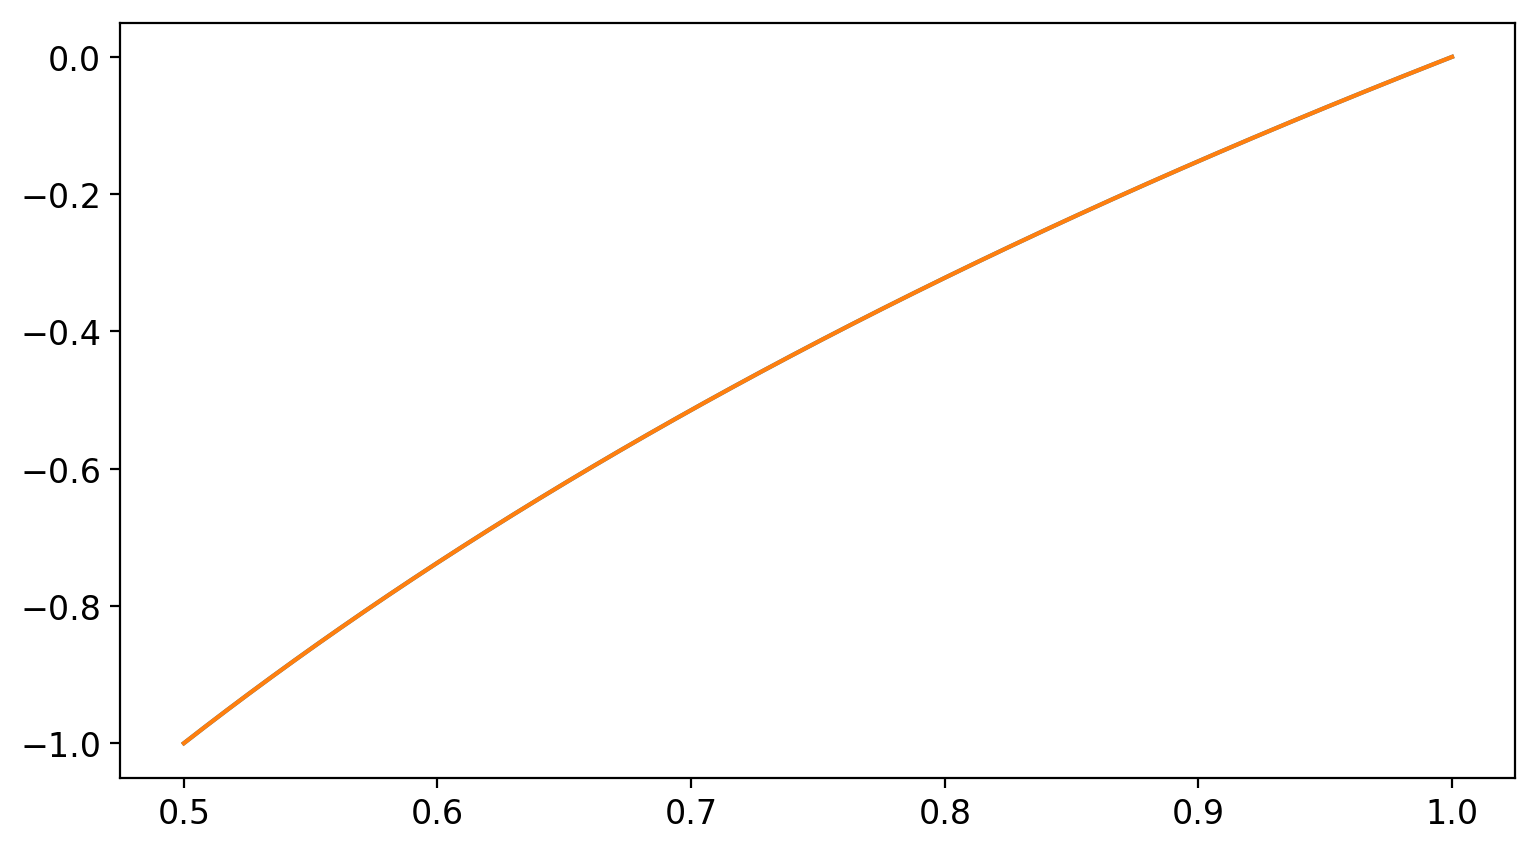

In [15]:
plt.plot(xvals, y_true)
plt.plot(xvals, y_est);

So far, so good. Looks like the lines lie on top of each other&mdash;now let's do some exploring with the order of the polynomial.

In [16]:
rms_errors = {}
min_errors = {}
max_errors = {}

# Explicitly re-define the function being used and the domain for good measure.
func = np.log2
xmin, xmax = 0.5, 1.0
for order in range(3, 20):
    coeffs = chebyshev_polyfit(func, order=order, xmin=xmin, xmax=xmax)
    xvals = np.linspace(xmin, xmax, 1000)
    cheb_basis = build_cheb_basis(rescale_domain(xvals), order)
    y_true = np.log2(xvals)
    y_fit = cheb_basis @ coeffs
    rms_errors[order] = np.std(y_true - y_fit)
    min_errors[order] = np.abs(y_true - y_fit).min()
    max_errors[order] = np.abs(y_true - y_fit).max()

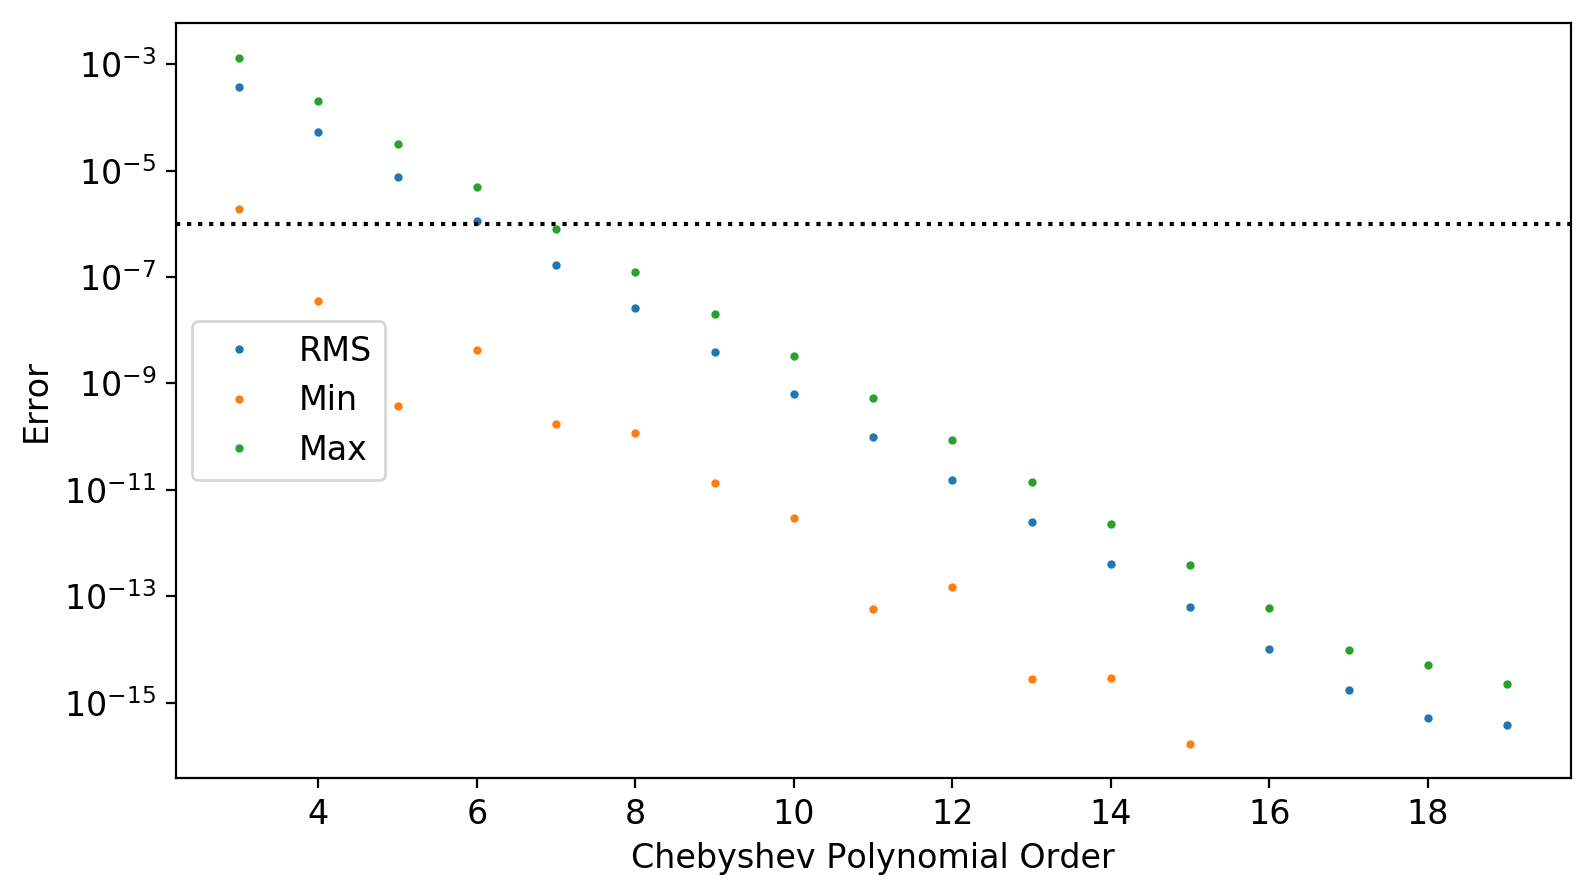

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Chebyshev Polynomial Order")
ax.set_ylabel("Error")
ax.set_yscale("log")
for label, errors in zip(("RMS", "Min", "Max"), (rms_errors, min_errors, max_errors)):
    ax.plot(list(errors.keys()), list(errors.values()), lw=0, marker="o", ms=2, label=label)
ax.axhline(1e-6, ls=":", color="k")
ax.legend(loc="center left");

It looks like we need to use at least a 7th-order Chebyshev polynomial in order to have the error be bound by $10^{-6}$ everywhere; however, some testing (omitted to keep clutter down and because I'm not keen on going there until after I've finished the rest of the problem set) shows that the order of the polynomial needed depends on the number of sample points used. Something curious is that if you build the Chebyshev basis using a square matrix with size `order + 1`, and do the fit using just those points with the base-2 logarithm values taken from `np.log2`, then the error is near machine precision for almost all orders. So I suspect that `numpy` uses something like a Chebyshev polynomial to calculate the base-2 logarithm under the hood. Anyway, with this in mind, I'll put the code for approximating the base-2 logarithm with a truncated Chebyshev polynomial in the following cell.

In [18]:
# First, let's get the coefficients for an 8th-order fit to np.log2, using 1001 points.
Npts = 1001
COEFFS = chebyshev_polyfit(np.log2, order=8, xmin=xmin, xmax=xmax, Npts=Npts)
def log2(x, coeffs=COEFFS):
    """
    Approximate the base-2 logarithm using a truncated Chebyshev polynomial.
    Valid on the interval [0.5, 1.0].
    
    Parameters
    ----------
    x: array-like of float
        x-values at which the base-2 logarithm is to be evaluated.
    coeffs: array-like of float
        Coefficients of the Chebyshev polynomial to use in the approximation.
        Default is to use the coefficients appropriate for an 8th-order fit to
        ``np.log2``.
        
    Returns
    -------
    approx_log2: array-like of float
        Array approximating the base-2 logarithm of the input x-values.
    """
    if not np.allclose([x[0], x[-1]], [0.5, 1], atol=1e-5):
        raise ValueError("Input x-values must start at 0.5 and end at 1.")
        
    cheb_basis = build_cheb_basis(
        rescale_domain(np.asarray(x)), coeffs.size - 1
    )
    return cheb_basis @ coeffs

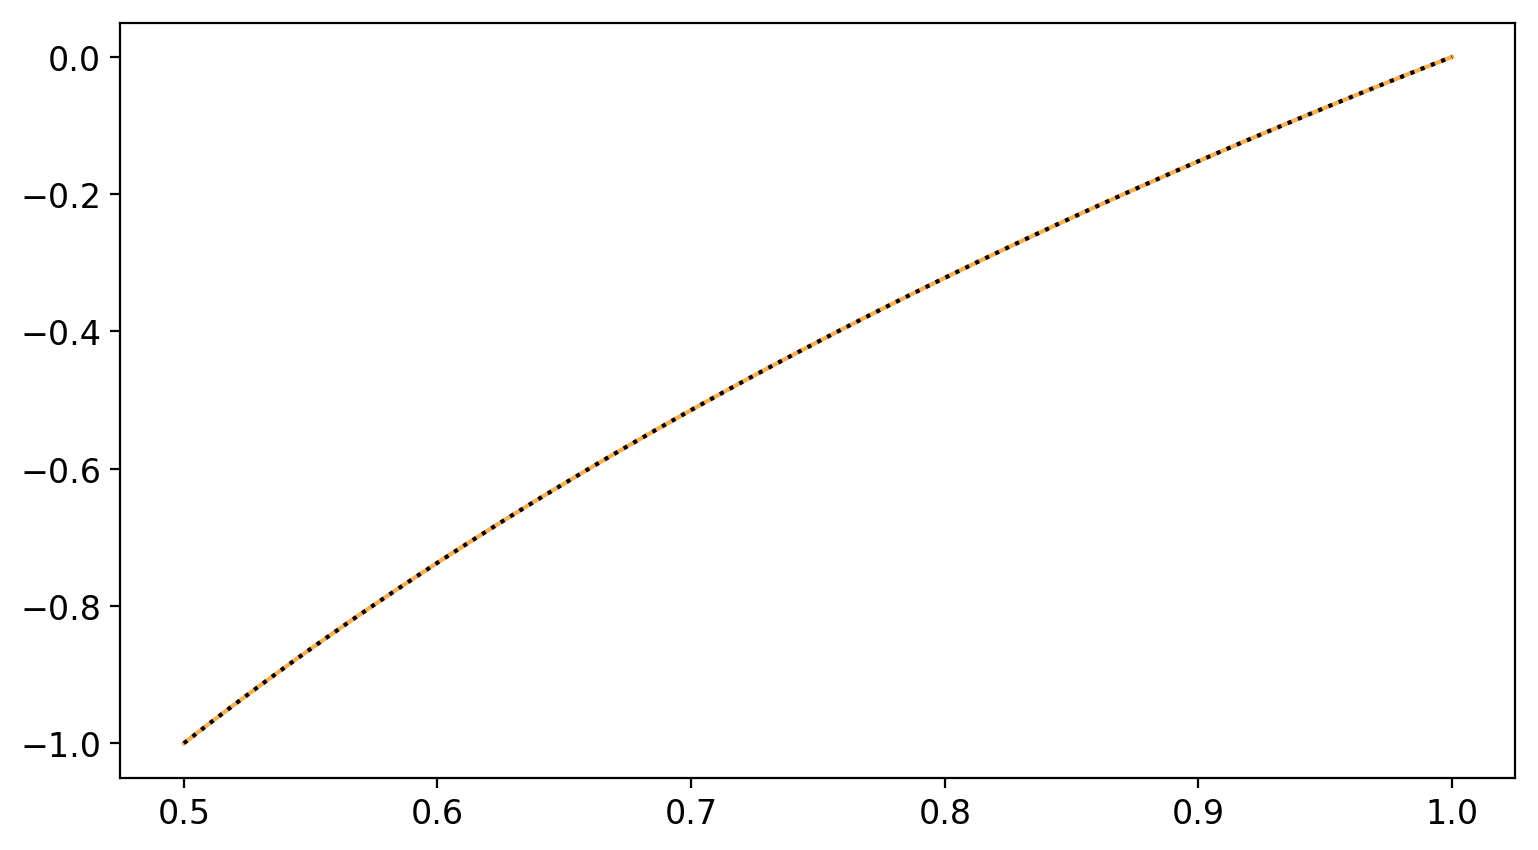

In [19]:
# Quick test that the function works.
test_xvals = np.linspace(0.5, 1.0, 55)
ref_log2 = np.log2(test_xvals)
approx_log2 = log2(test_xvals)
plt.plot(test_xvals, ref_log2, color="darkorange", alpha=0.7)
plt.plot(test_xvals, approx_log2, ls=":", color="k");

In [20]:
# Compare Legendre polyfit to Chebyshev polyfit for fixed order
# First, get the coefficients *using the same setup as for the Chebyshev fit*
xmin, xmax = 0.5, 1.0
order = COEFFS.size - 1
xvals = np.linspace(xmin, xmax, Npts) # Use the same parameters as above.
yvals = np.log2(xvals)
leg_coeffs = legfit(xvals, yvals, order)

# Evaluate the polynomials and calculate the errors.
leg_fit = legval(xvals, leg_coeffs)
cheb_fit = log2(xvals)
leg_errors = leg_fit - yvals
cheb_errors = cheb_fit - yvals
rms_leg_error = np.std(leg_errors)
rms_cheb_error = np.std(cheb_errors)

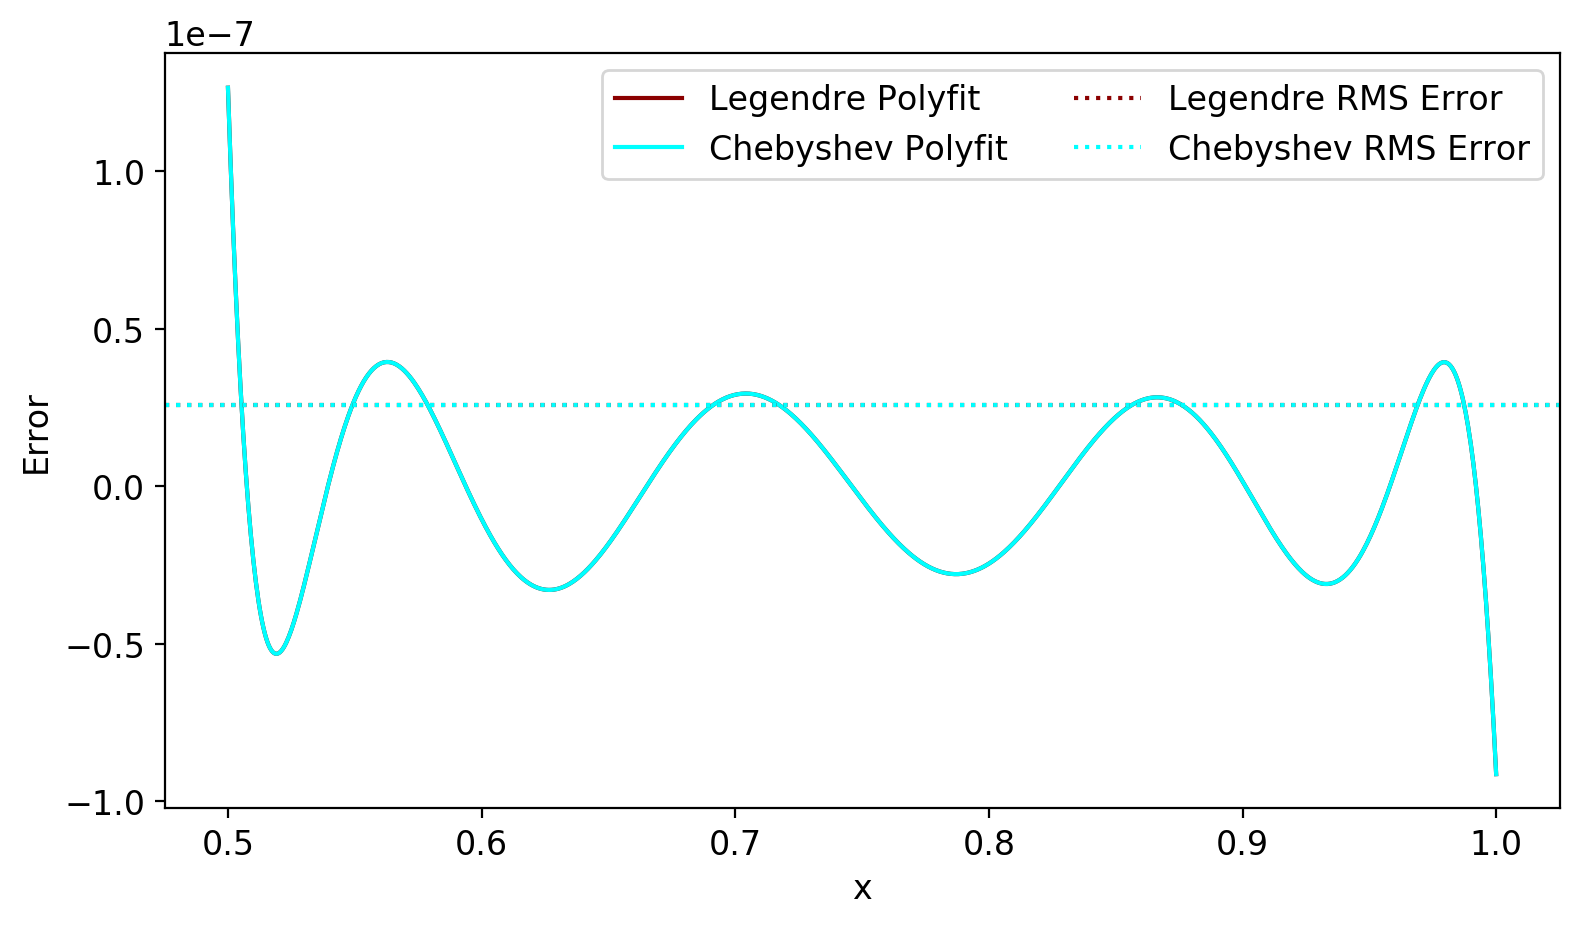

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("x")
ax.set_ylabel("Error")
ax.plot(xvals, leg_errors, color="darkred", label="Legendre Polyfit")
ax.plot(xvals, cheb_errors, color="cyan", label="Chebyshev Polyfit")
ax.axhline(rms_leg_error, color="darkred", ls=":", label="Legendre RMS Error")
ax.axhline(rms_cheb_error, color="cyan", ls=":", label="Chebyshev RMS Error")
ax.legend(ncol=2);

So this is a little unexpected given the prompt of the problem. Apparently, if I use exactly the same setup for carrying out both the Legendre polyfit and the Chebyshev polyfit, then I get identical results for the residuals and RMS errors. Important to note, however, is that this changes if the number of sample points used differs between the two fitting routines. I'll quickly show this effect in the following cells.

In [22]:
xmin, xmax = 0.5, 1.0
order = 8

# Calculate the coefficients for the two fits using different numbers of points.
leg_xvals = np.linspace(xmin, xmax, 11)
leg_yvals = np.log2(leg_xvals)
leg_coeffs = legfit(leg_xvals, leg_yvals, order)
cheb_coeffs = chebyshev_polyfit(
    func=np.log2, xmin=xmin, xmax=xmax, order=order, Npts=15
)

# Evaluate the polynomials and calculate the residuals.
xvals = np.linspace(xmin, xmax, 1001)
yvals = np.log2(xvals)
leg_fit = legval(xvals, leg_coeffs)
cheb_fit = log2(xvals, coeffs=cheb_coeffs)
leg_resid = yvals - leg_fit
cheb_resid = yvals - cheb_fit
leg_rms_error = np.std(leg_resid)
cheb_rms_error = np.std(cheb_resid)

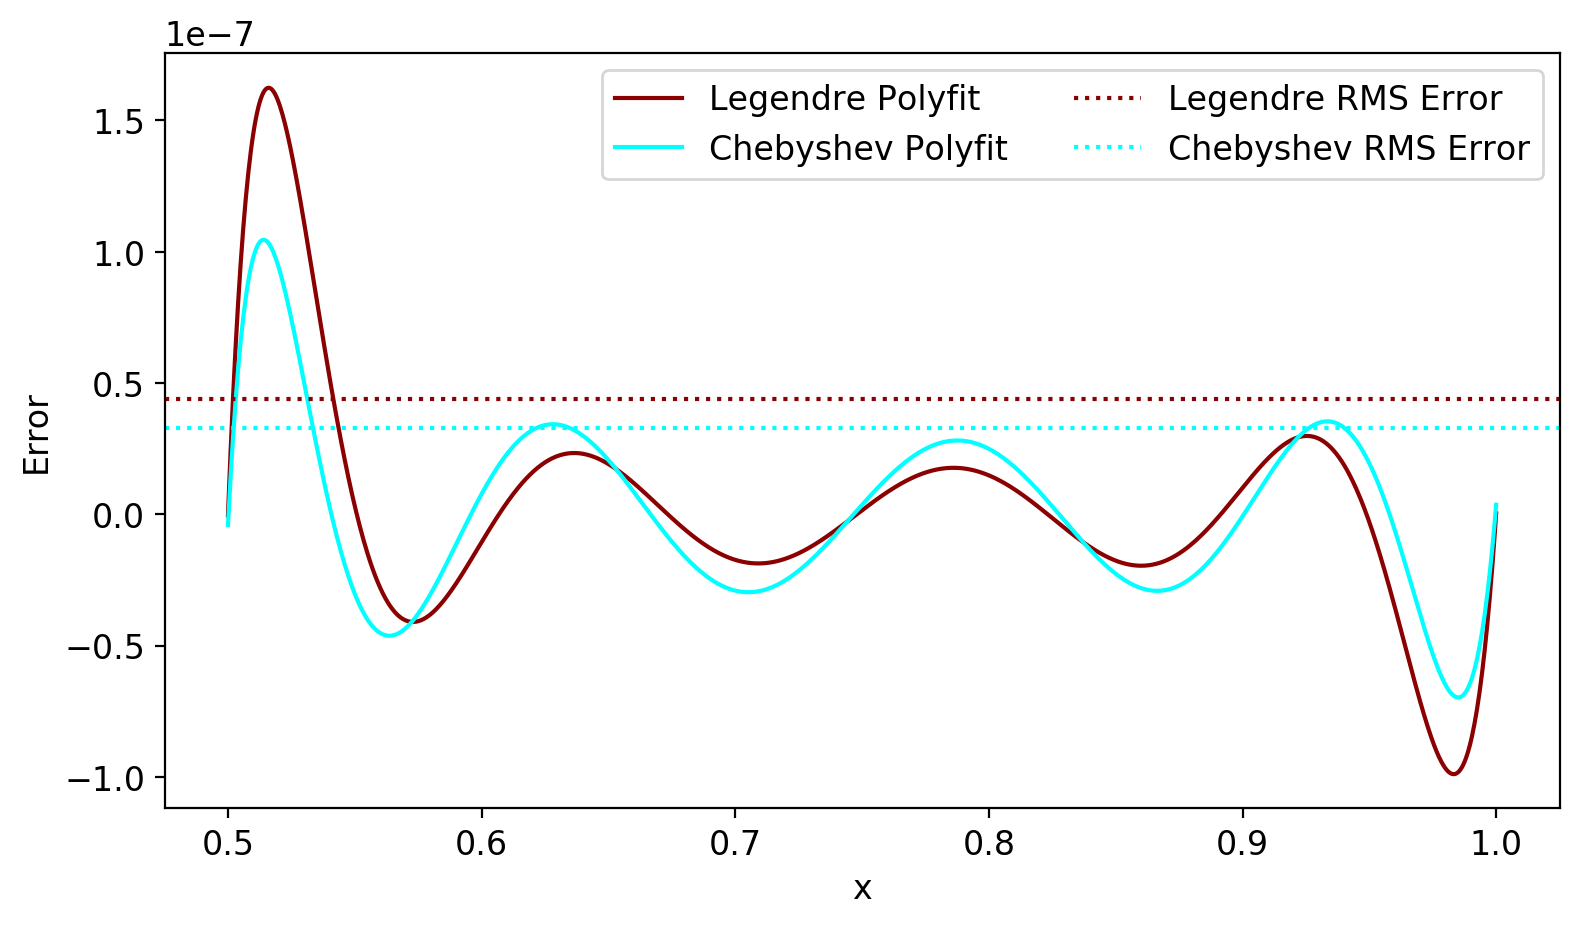

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("x")
ax.set_ylabel("Error")
ax.plot(xvals, leg_resid, color="darkred", label="Legendre Polyfit")
ax.plot(xvals, cheb_resid, color="cyan", label="Chebyshev Polyfit")
ax.axhline(leg_rms_error, color="darkred", ls=":", label="Legendre RMS Error")
ax.axhline(cheb_rms_error, color="cyan", ls=":", label="Chebyshev RMS Error")
ax.legend(ncol=2);

The above plot shows that the fit generated using more data points produces a fit that has both a smaller RMS error and a smaller maximum error.

## Problem 3

For this problem, we consider the decay of U-238 into various other elements. Let's first enumerate the various half-lives.

In [24]:
# Enumerate the decay chain. Pulled from the table shown in lecture.
half_lives = {
    "U-238": 4.468 * units.Gyr.to("s"),
    "Th-234": 24.10 * units.day.to("s"),
    "Pa-234": 6.70 * units.hour.to("s"),
    "U-234": 245500 * units.yr.to("s"),
    "Th-230": 75380 * units.yr.to("s"),
    "Ra-226": 1600 * units.yr.to("s"),
    "Rn-222": 3.8235 * units.day.to("s"),
    "Po-218": 3.10 * units.minute.to("s"),
    "Pb-214": 26.8 * units.minute.to("s"),
    "Bi-214": 19.9 * units.minute.to("s"),
    "Po-214": 164.3 * units.us.to("s"),
    "Pb-210": 22.3 * units.yr.to("s"),
    "Bi-210": 5.015 * units.yr.to("s"),
    "Po-210": 138.376 * units.day.to("s"),
    "Pb-206": np.inf,
}

### Part a

For this problem, we are asked to solve for the decay products of U-238 using the entire decay chain. To do this, I'll use `scipy.integrate.solve_ivp` with the setting `method="Radau"`, since we have a stiff system of differential equations here.

In [25]:
# First, write a function giving the derivative as a function of the inputs.
def decay_chain(time, amounts, half_lives=list(half_lives.values())[:-1]):
    """
    Function for giving the decay rates for all elements in a given
    *sequential* decay chain. This will be incorrect for systems where
    a given element in the chain has multiple decay paths.
    
    Parameters
    ----------
    time: anything
        The decay rates are time-independent, so this is just a dummy input.
    amounts: array-like of float
        The amount of each element in the decay chain. The first entry is the
        first element in the decay chain, and the last entry is the stable element
        at the end of the decay chain. Units can be whatever is sensible (e.g. grams).
    half_lives: array-like of float
        The half life for each element in the decay chain, modulo the stable element
        at the end of the chain. (So this should have length that is one less than
        the length of the ``amounts`` input.) Should have units of time, with each entry
        having the same units as all other entries.
        
    Returns
    -------
    decay_rates: ndarray of float
        The decay rate for each unstable element in the decay chain.
    """
    if len(amounts) != len(half_lives) + 1:
        raise ValueError("There should be one less half life than number of species.")
        
    decay_rates = np.zeros_like(amounts, dtype=np.float)
    decay_rates[0] = -amounts[0] / half_lives[0]
    for i in range(1, len(half_lives)):
        decay_rates[i] = amounts[i-1] / half_lives[i-1] - amounts[i] / half_lives[i]
    decay_rates[-1] = amounts[-2] / half_lives[-2]
    
    return decay_rates

In [26]:
initial_amounts = dict(zip(half_lives.keys(), [1,] + [0] * (len(half_lives) - 1)))
# As a first test, let's see what happens over just a few hundred years.
t0, tf = 0, 500 * units.yr.to("s")
solution = solve_ivp(decay_chain, [t0, tf], list(initial_amounts.values()), method="Radau")
final_amounts = solution.y
times = solution.t
times_yr = times * units.s.to("yr")

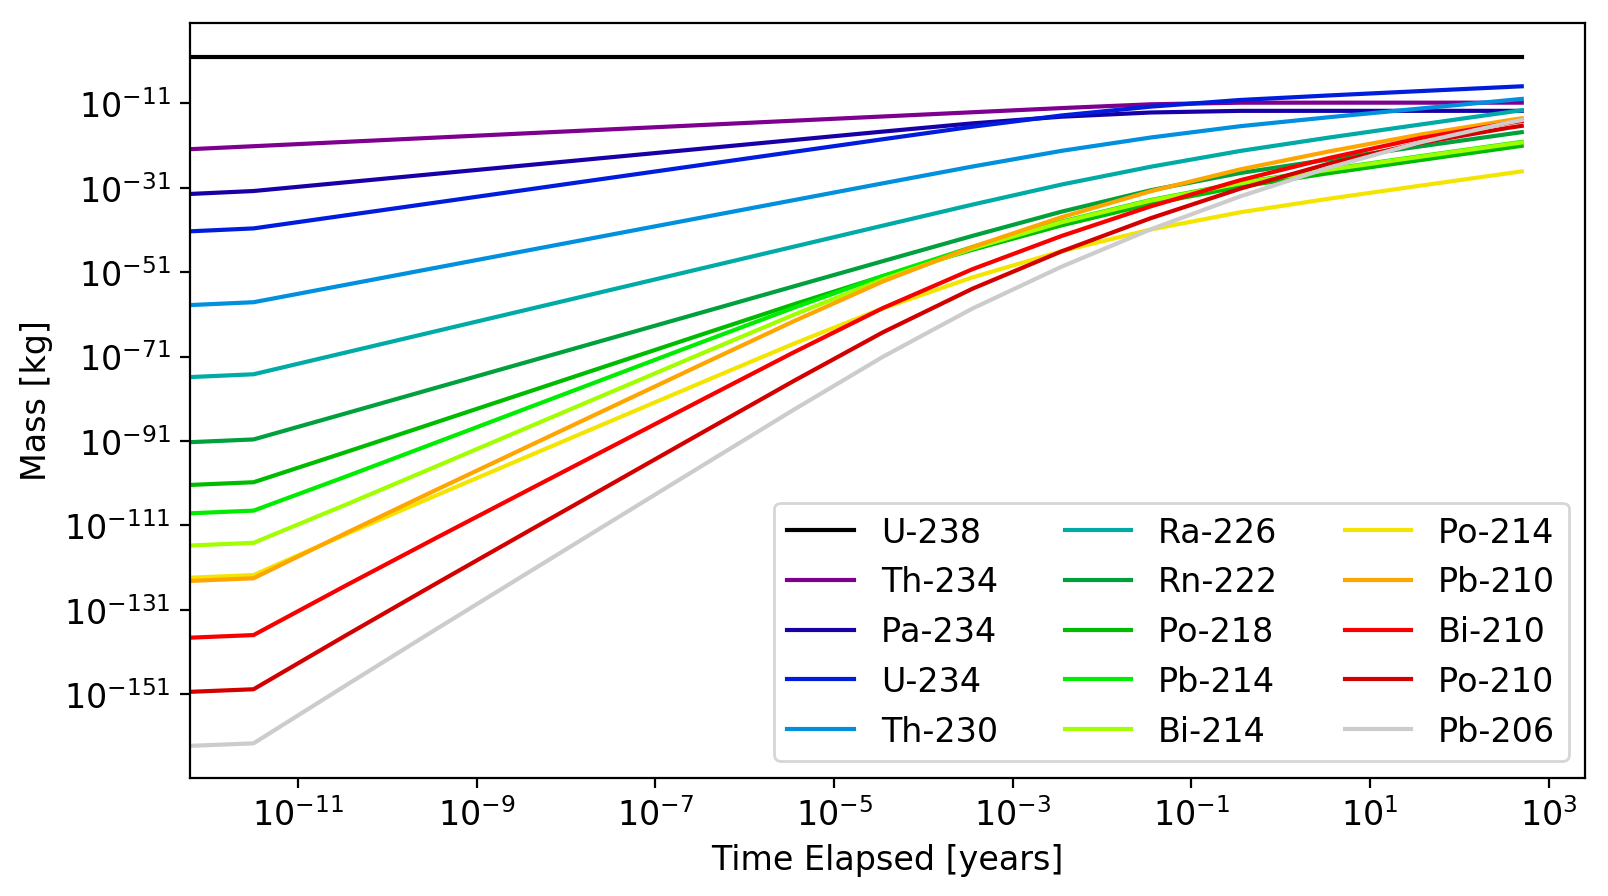

In [27]:
colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(initial_amounts)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Time Elapsed [years]")
ax.set_ylabel("Mass [kg]")
for element, amount, color in zip(half_lives.keys(), final_amounts, colors):
    ax.loglog(times_yr, amount, color=color, label=element)
ax.legend(ncol=len(half_lives) // 5);

In [28]:
# Now let's do it over ten billion years
initial_amounts = dict(zip(half_lives.keys(), [1,] + [0] * (len(half_lives) - 1)))
t0, tf = 0, 40 * units.Gyr.to("s")
t_eval = None # np.logspace(-10, np.log10(tf), 5000)
solution = solve_ivp(
    decay_chain, [t0, tf], list(initial_amounts.values()),
    t_eval=t_eval, method="Radau"
)
final_amounts = solution.y
times = solution.t
times_yr = times * units.s.to("yr")

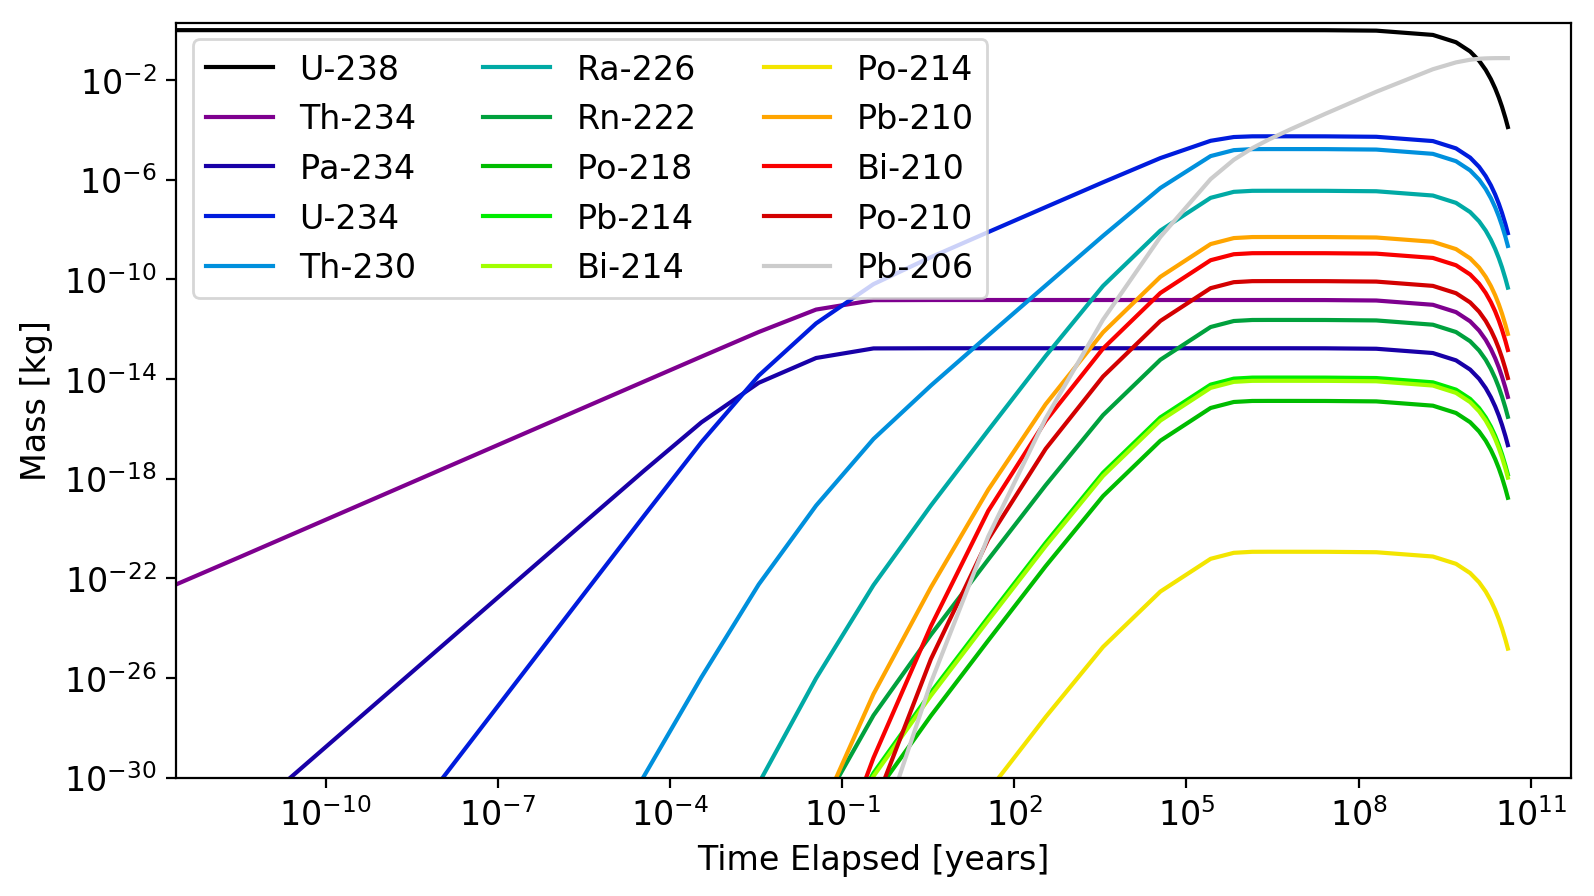

In [29]:
colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(initial_amounts)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Time Elapsed [years]")
ax.set_ylabel("Mass [kg]")
ax.set_ylim(1e-30, 2)
for element, amount, color in zip(half_lives.keys(), final_amounts, colors):
    ax.loglog(times_yr, amount, color=color, label=element)
ax.legend(ncol=len(half_lives) // 5);

### Part b

Analytically, the amount of U-238 remaining after a time $t$ is given by
  
$$
m_{U_{238}}(t) = m_{U_{238},0}2^{-t/t_\mathrm{half}},
$$  
  
where $t_\mathrm{half}$ is the half-life of U-238. Approximating the decay process as a decay free from intermediate products so that U-238 $\rightarrow$ Pb-206 upon each decay, the amount of Pb-206 after a time $t$ is given by
  
$$
m_{Pb_{206}}(t) = m_{U_{238},0}(1 - 2^{-t/t_\mathrm{half}}).
$$
  
This gives an expected ratio after a time $t$ of
  
$$
R_{Pb_{206}/U_{238}}(t) = 2^{t/t_\mathrm{half}} - 1.
$$

In [30]:
u238_half_life = half_lives["U-238"]
analytic_pb_to_u_ratio = 2 ** (times / u238_half_life) - 1

/home/bobby/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


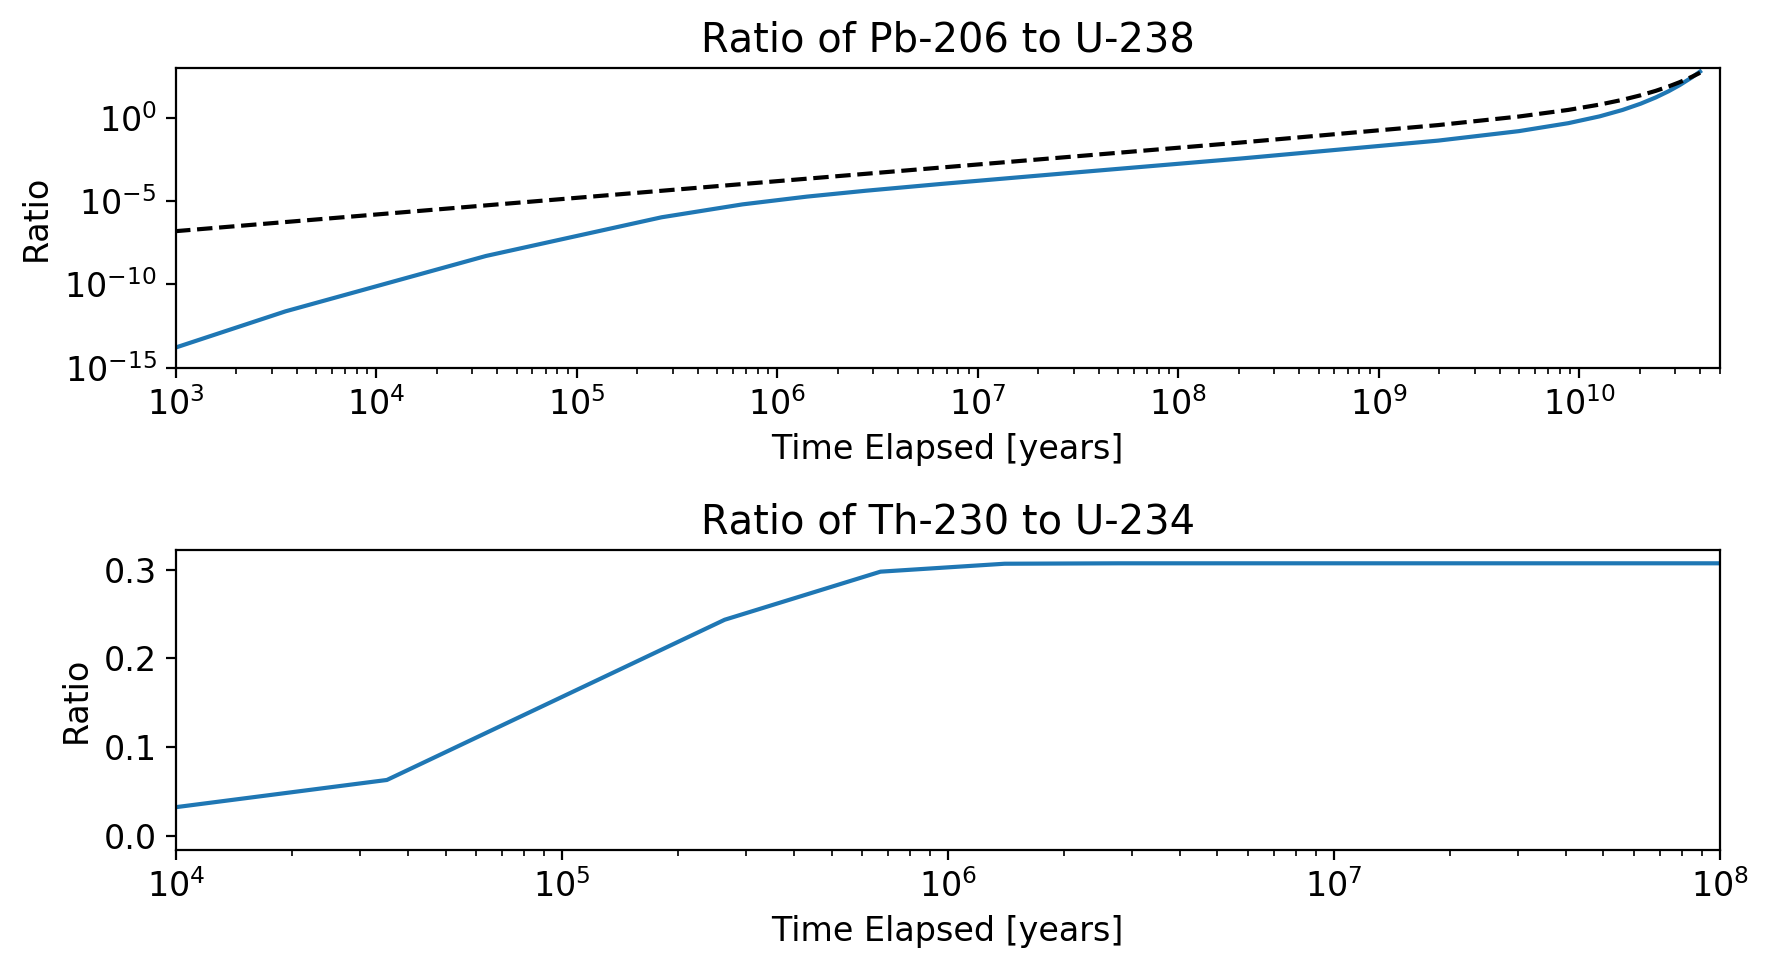

In [31]:
lead_to_uranium_ratio = final_amounts[-1] / final_amounts[0]
th230_index = 4
u234_index = 3
thorium_to_uranium_ratio = final_amounts[th230_index] / final_amounts[u234_index]
thorium_to_uranium_ratio[np.isnan(thorium_to_uranium_ratio)] = 0
fig = plt.figure()
axes = fig.subplots(2)
axes[0].set_title("Ratio of Pb-206 to U-238")
axes[1].set_title("Ratio of Th-230 to U-234")
for ax in axes:
    ax.set_xlabel("Time Elapsed [years]")
    ax.set_ylabel("Ratio")
axes[0].loglog(times_yr, lead_to_uranium_ratio)
axes[0].loglog(times_yr, analytic_pb_to_u_ratio, color="k", ls="--")
axes[1].semilogx(times_yr, thorium_to_uranium_ratio)
axes[0].set_xlim(1e3, 5e10)
axes[0].set_ylim(1e-15, 1e3)
axes[1].set_xlim(1e4, 1e8)
fig.tight_layout()

In the top plot, the numerical ratio (solid blue line) of Pb-206 to U-238 is shown against the analytic expectation (dashed black line) derived by assuming the intermediate decay products are skipped in the decay process. The analytic expectation does pretty poorly at times less than about the half-life of U-234, but does a bit better beyond there, and appears to do quite well as we get to about 5 U-238 half-lives. The poor behavior at times less than the U-234 half-life is expected, since the U-234 is effectively a rate-limiting step and ignoring it at times less than the expected decay time is bound to lead to errors. The disagreement at later times is somewhat surprising, though I generally expect the analytic expectation to over-estimate the ratio of Pb-206 to U-238, since some of the intermediate products will reach a steady state (and effectively lock up some fraction of the mass) until the U-238 is depleted.
  
In the bottom plot, the ratio of Th-230 to U-234 is plotted. We see that after a few U-234 half-lives the ratio asymptotes to 0.3, which is expected since that's about the ratio of the Th-230 half-life to the U-234 half-life. Looking at these plots, I'm not quite sure I agree with the claim made at the end of the problem prompt&mdash;it looks like the ratio of U-234 to Th-230 gets locked in beyond a certain time, but looks like a useful tool for dating rocks that are on the order of tens-to-hundreds of thousands of years old. From these plots, I would think that the Th-230 to U-234 ratio is useful for younger rocks and the U-238 to Pb-206 ratio is better for older rocks.